# Inspect masks and predictions
## Masks
### Generated Masks from raw Data
Show a random mask generated with the [script](../own_scripts/generate_masks_from_JSON.py) using the JSON with the corresponding annotations.

In [31]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
data_root = "../../nnNet_training/Raw_data/Dataset_train_val"
image_dir = os.path.join(data_root, "imagesTr")
mask_dir = os.path.join(data_root, "labelsTr")

def load_random_image_and_mask():
    """Loads a random image and its corresponding mask."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    if not image_files:
        print("No images found.")
        return None, None, None
    
    random_image = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image)
    mask_filename = random_image.replace("_0000.png", ".png")  # Ensure correct mapping
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if not os.path.exists(mask_path):
        print(f"Mask not found for {random_image}")
        return None, None, None
    
    return Image.open(image_path), Image.open(mask_path), random_image

def visualize_image_and_mask():
    """Plots a random image and its corresponding mask."""
    image, mask, filename = load_random_image_and_mask()
    
    if image is None or mask is None:
        print("Could not load image and mask.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    #axes[0].imshow(image, cmap="gray" if image.mode == "L" else None) # this is for binary masks
    axes[0].imshow(image)
    axes[0].set_title(f"Original Image\n{filename}")
    axes[0].axis("off")
    
    axes[1].imshow(mask, cmap="jet") #cmap="gray" for binary masks
    axes[1].set_title("Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_image_and_mask()

No images found.
Could not load image and mask.


## Verifiy unique labels (multiclass)

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Set your paths
data_root = "../../nnNet_training/Raw_data/Dataset_train_val"
image_dir = os.path.join(data_root, "imagesTr")
mask_dir = os.path.join(data_root, "labelsTr")

# Pick a random image-mask pair to inspect
filename = random.choice([
    f for f in os.listdir(image_dir) if f.endswith(".png")
])
image_path = os.path.join(image_dir, filename)
mask_path = os.path.join(mask_dir, filename.replace("_0000.png", ".png"))

# Load image and mask
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Preserve original dtype
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Preserve label values

# Display shapes
print(f"🖼️ Image: {filename} — Shape: {image.shape}, Dtype: {image.dtype}")
print(f"🎭 Mask:  {os.path.basename(mask_path)} — Shape: {mask.shape}, Dtype: {mask.dtype}")

# Get unique labels in the mask
unique_labels = np.unique(mask)
print(f"\n🏷️ Unique labels in mask: {unique_labels.tolist()}")
print(f"Total distinct labels (incl. background): {len(unique_labels)}")

# Optional: visualize image + mask
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image, cmap="gray") 
axs[0].set_title("Image")
axs[0].axis("off")

im = axs[1].imshow(mask, cmap="tab20")  # or "nipy_spectral", "gist_ncar"
axs[1].set_title("Mask (Class Labels)")
axs[1].axis("off")

# Add colorbar for mask classes
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

IndexError: Cannot choose from an empty sequence

🔍 Scanning masks for label frequencies...



0it [00:00, ?it/s]


✅ Label Frequencies:


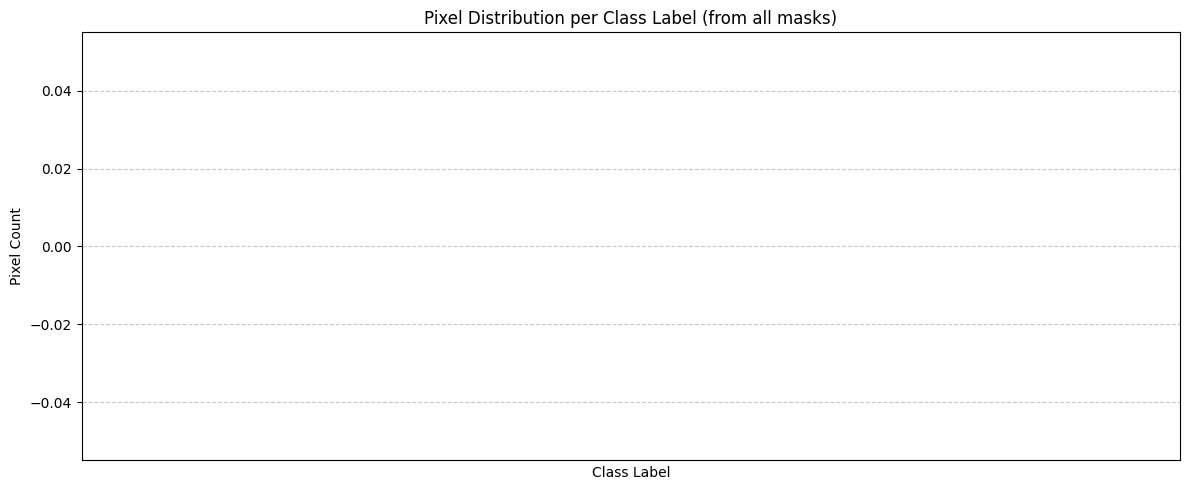

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from tqdm import tqdm

# Paths
data_root = "../../nnNet_training/Raw_data/Dataset_train_val"
mask_dir = os.path.join(data_root, "labelsTr")
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Count label occurrences
label_counts = Counter()

print("🔍 Scanning masks for label frequencies...\n")
for mask_file in tqdm(mask_files):
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    labels, counts = np.unique(mask, return_counts=True)
    label_counts.update(dict(zip(labels, counts)))

# Sort by label
sorted_counts = dict(sorted(label_counts.items()))

# Print summary
print("\n✅ Label Frequencies:")
for label, count in sorted_counts.items():
    print(f"Class {label:>2}: {count:,} pixels")

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Pixel Count")
plt.title("Pixel Distribution per Class Label (from all masks)")
plt.xticks(list(sorted_counts.keys()))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Selected Images with no masks
During the mask generation some masks seem to have no annotations. We try to look at them and ensure, it's not an error in the implementation.

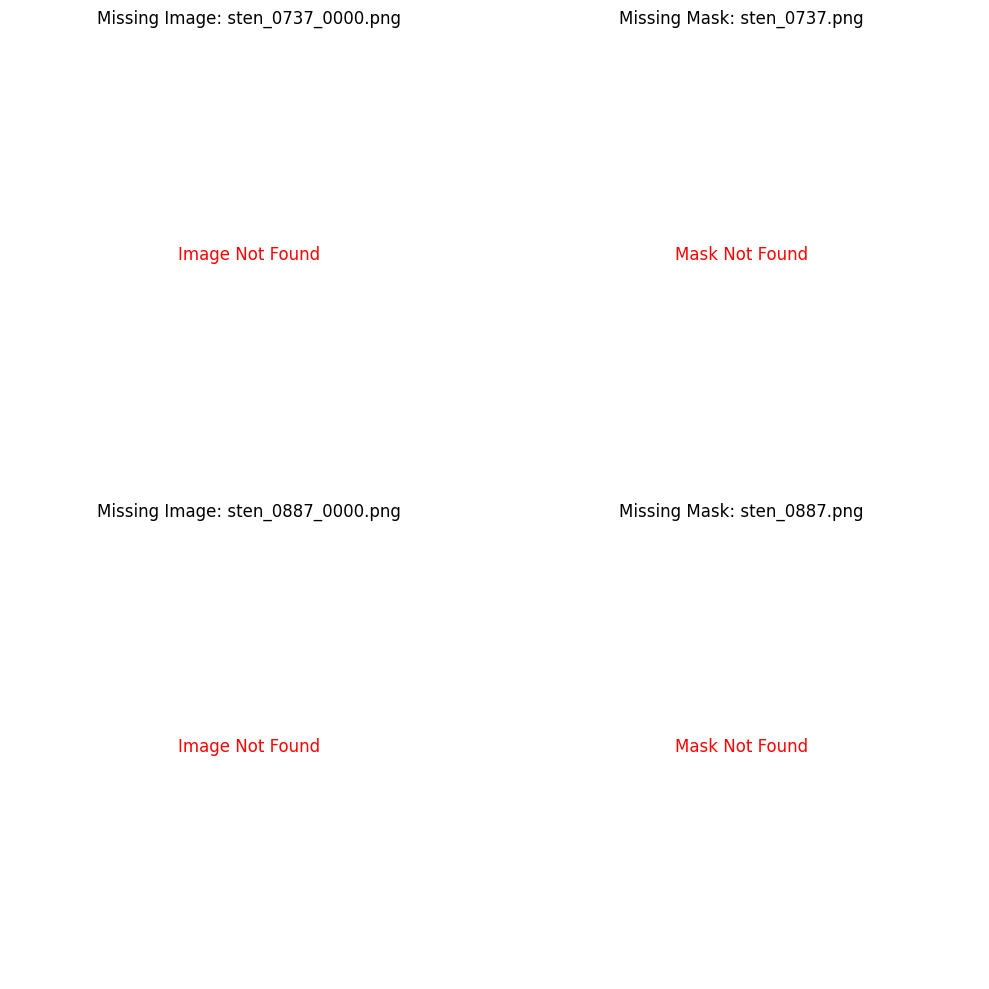

In [35]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths for images and masks
image_paths = [
    "../../nnNet_training/Raw_data/Dataset_Train_val/imagesTr/sten_0737_0000.png",
    "../../nnNet_training/Raw_data/Dataset_Train_val/imagesTr/sten_0887_0000.png"
]

mask_paths = [
    "../../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/sten_0737.png",
    "../../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/sten_0887.png"
    ]

def load_image(image_path):
    """Load an image if it exists, otherwise return None."""
    if os.path.exists(image_path):
        return Image.open(image_path)
    return None

# Plot images and masks
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    img = load_image(img_path)
    mask = load_image(mask_path)

    # Plot Image
    axes[i, 0].axis("off")
    if img:
        axes[i, 0].imshow(img, cmap="gray" if img.mode == "L" else None)
        axes[i, 0].set_title(f"Image: {os.path.basename(img_path)}")
    else:
        axes[i, 0].text(0.5, 0.5, "Image Not Found", color="red", fontsize=12, ha="center")
        axes[i, 0].set_title(f"Missing Image: {os.path.basename(img_path)}")

    # Plot Mask
    axes[i, 1].axis("off")
    if mask:
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask: {os.path.basename(mask_path)}")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", color="red", fontsize=12, ha="center")
        axes[i, 1].set_title(f"Missing Mask: {os.path.basename(mask_path)}")

plt.tight_layout()
plt.show()

### Comaparison GT Segmentation and manually generated Masks
In the README.md there is a hint that the folder structure should look the way it's described. There is also a labelsTr folder, therefore we have a script, which manually generates the script. But during the training process, the generation of the masks is also part. Therefore i want to look at bot of them if they look the same way.

In [36]:
path_gt = "../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/"
path_lables = "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/"

# Load mask
mask = Image.open(os.path.join(path_gt, "sten_0005.png"))
mask1 = Image.open(os.path.join(path_lables, "sten_0005.png"))

FileNotFoundError: [Errno 2] No such file or directory: '../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/sten_0005.png'

AttributeError: 'NoneType' object has no attribute 'mode'

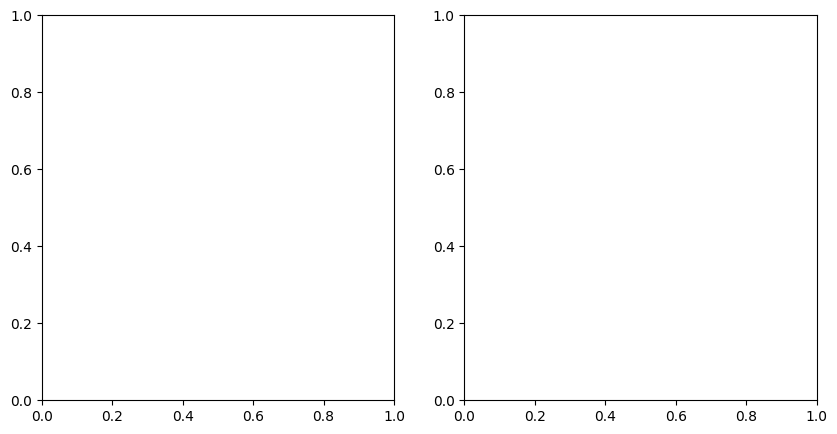

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap="gray" if mask.mode == "L" else None)
axes[0].set_title(f"Gt Segmentation")
axes[0].axis("off")

axes[1].imshow(mask1, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Predictions
During training we used fold x (can be changed) for the validation. In the summary.json file in the validation folder there is the prediction with its scores for each case. We want to look at them and ensure its correctness.

### Validation set

In [38]:
# Just show one selected image

path_pred = "../nnNet_training/nnUNet_results/Dataset_Train_val/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/sten_0109.png"
path_gt = "../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/sten_0109.png"

# Function to compute IoU and Dice Score
def compute_iou_dice(gt_mask, pred_mask):
    """Compute IoU and Dice Score between GT and predictions."""
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union != 0 else 0.0
    dice = (2 * intersection) / (gt_mask.sum() + pred_mask.sum()) if (gt_mask.sum() + pred_mask.sum()) != 0 else 0.0
    return iou, dice

score = compute_iou_dice(np.array(Image.open(path_gt)), np.array(Image.open(path_pred)))

# Plot the images and the score on the prediction
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(Image.open(path_gt), cmap="gray")
axes[0].set_title("Ground Truth")
axes[0].axis("off")

axes[1].imshow(Image.open(path_pred), cmap="gray")
axes[1].set_title(f"Prediction\nIoU: {score[0]:.2f}, Dice: {score[1]:.2f}")
axes[1].axis("off")

FileNotFoundError: [Errno 2] No such file or directory: '../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/sten_0109.png'

Thsi is exactly the dice and IoU score which is in the summary.json file.

### Test
We also have the predictions for the test set, but not the scores. Therefore we want to inspect them and look at the scores.

In [ ]:
path_test = "../../dataset_test_pretrained_own_test"
path_raw_data = "raw"
path_labels = "labels"
path_preprocessed_data = "preprocessed"
path_raw_prediction = "raw_prediction"
path_post_prediction = "post_prediction"

path_mask = "sten_0054.png"
path_mask_1 = "sten_0054_0000.png"

full_raw_path = os.path.join(path_test, path_raw_data, path_mask_1)
full_preprocessed_path = os.path.join(path_test, path_preprocessed_data, path_mask_1)
full_raw_prediction_path = os.path.join(path_test, path_raw_prediction, path_mask)
full_post_prediction_path = os.path.join(path_test, path_post_prediction, path_mask)
full_mask_path = os.path.join(path_test, path_labels, path_mask)



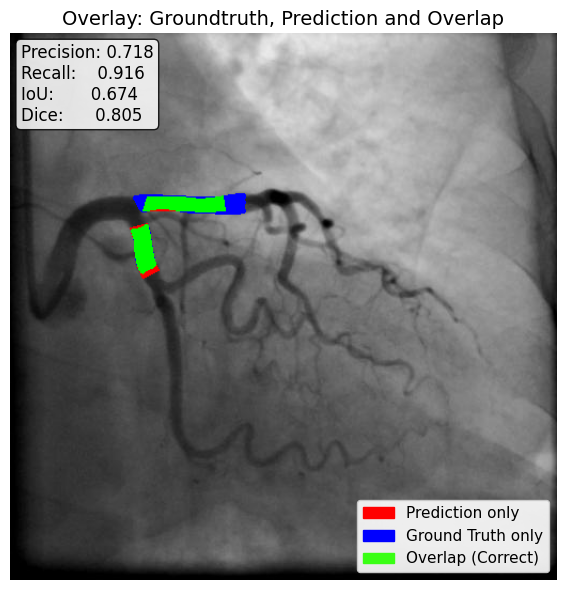

In [79]:
from sklearn.metrics import precision_score, recall_score
from collections import Counter
from matplotlib.patches import Patch

# Load images
image = cv2.imread("/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0010_0000.png")
gt_mask = cv2.imread("/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0010-3.png")
preprocessed_image = cv2.imread(full_preprocessed_path)
pred_mask = cv2.imread("/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0010_unet.png")
post_prediction_mask = cv2.imread(full_post_prediction_path)

# --- Assume: image, gt_mask, pred_mask already loaded ---
gt_bin = (gt_mask > 0).astype(np.uint8)
pred_bin = (pred_mask > 0).astype(np.uint8)

# Metrics
intersection = np.logical_and(gt_bin, pred_bin).sum()
union = np.logical_or(gt_bin, pred_bin).sum()
iou = intersection / union if union != 0 else 0.0
dice = (2 * intersection) / (gt_bin.sum() + pred_bin.sum()) if (gt_bin.sum() + pred_bin.sum()) != 0 else 0.0
precision = precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0)
recall = recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0)

# Convert grayscale to BGR
if len(image.shape) == 2 or image.shape[2] == 1:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay = image.copy()

# Get coordinates
overlap_coords = np.where((gt_bin == 1) & (pred_bin == 1))
gt_only_coords = np.where((gt_bin == 1) & (pred_bin == 0))
pred_only_coords = np.where((gt_bin == 0) & (pred_bin == 1))

# Apply colors
overlay[gt_only_coords[0], gt_only_coords[1]] = [0, 0, 255]     # Blue = GT only
overlay[pred_only_coords[0], pred_only_coords[1]] = [255, 0, 0] # Red = Pred only
overlay[overlap_coords[0], overlap_coords[1]] = [0, 255, 0]     # Green = Overlap

# Convert for plotting
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(overlay_rgb)
ax.set_title("Overlay: Groundtruth, Prediction and Overlap", fontsize=14)
ax.axis("off")

# Metrics box
metrics_text = (
    f"Precision: {precision:.3f}\n"
    f"Recall:    {recall:.3f}\n"
    f"IoU:       {iou:.3f}\n"
    f"Dice:      {dice:.3f}"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.85)
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=props)

# Legend with correct color mapping
legend_patches = [
    Patch(color='red', label='Prediction only'),
    Patch(color='blue', label='Ground Truth only'),
    Patch(color='#39FF14', label='Overlap (Correct)')
]
ax.legend(handles=legend_patches, loc='lower right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import precision_score, recall_score

# --- Define your file paths ---
full_raw_path = 'your_path/image.png'
full_mask_path = 'your_path/gt_mask.png'
full_pred1_path = 'your_path/pred_unet.png'
full_pred2_path = 'your_path/pred_attentionunet.png'

# --- Load images ---
image = cv2.imread(full_raw_path)
gt_mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
pred1_mask = cv2.imread(full_pred1_path, cv2.IMREAD_GRAYSCALE)
pred2_mask = cv2.imread(full_pred2_path, cv2.IMREAD_GRAYSCALE)

# --- Binarize masks ---
gt_bin = (gt_mask > 0).astype(np.uint8)
pred1_bin = (pred1_mask > 0).astype(np.uint8)
pred2_bin = (pred2_mask > 0).astype(np.uint8)

# --- Metric computation for both models ---
def compute_metrics(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    dice = (2 * intersection) / (gt.sum() + pred.sum()) if (gt.sum() + pred.sum()) != 0 else 0.0
    iou = intersection / union if union != 0 else 0.0
    precision = precision_score(gt.flatten(), pred.flatten(), zero_division=0)
    recall = recall_score(gt.flatten(), pred.flatten(), zero_division=0)
    return precision, recall, iou, dice

metrics1 = compute_metrics(gt_bin, pred1_bin)
metrics2 = compute_metrics(gt_bin, pred2_bin)

# --- Overlay setup ---
if len(image.shape) == 2 or image.shape[2] == 1:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay = image.copy()

# Colors: pred1 = red, pred2 = purple, gt = blue, overlap = green
# Areas: overlap1 = pred1 & gt, overlap2 = pred2 & gt, pred1_only, pred2_only, gt_only

overlap1 = (gt_bin == 1) & (pred1_bin == 1)
overlap2 = (gt_bin == 1) & (pred2_bin == 1)
pred1_only = (pred1_bin == 1) & (gt_bin == 0)
pred2_only = (pred2_bin == 1) & (gt_bin == 0)
gt_only = (gt_bin == 1) & (pred1_bin == 0) & (pred2_bin == 0)

# Apply colors
overlay[gt_only] = [0, 0, 255]           # Blue = GT only
overlay[pred1_only] = [255, 0, 0]        # Red = UNet pred only
overlay[pred2_only] = [128, 0, 128]      # Purple = Attention UNet pred only
overlay[overlap1] = [0, 255, 0]          # Green = UNet overlap
overlay[overlap2] = [0, 255, 255]        # Cyan = AttentionUNet overlap

# Convert for plotting
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(overlay_rgb)
ax.set_title("Overlay: Ground Truth, UNet & AttentionUNet Predictions", fontsize=14)
ax.axis("off")

# Combine metrics display
metrics_text = (
    f"[UNet]     Dice: {metrics1[3]:.3f}  | IoU: {metrics1[2]:.3f}\n"
    f"           Prec: {metrics1[0]:.3f} | Recall: {metrics1[1]:.3f}\n\n"
    f"[AttUNet]  Dice: {metrics2[3]:.3f}  | IoU: {metrics2[2]:.3f}\n"
    f"           Prec: {metrics2[0]:.3f} | Recall: {metrics2[1]:.3f}"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.85)
ax.text(1.02, 1.0, metrics_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', bbox=props)

# Legend
legend_patches = [
    Patch(color='red', label='UNet Prediction only'),
    Patch(color='purple', label='AttentionUNet Prediction only'),
    Patch(color='blue', label='Ground Truth only'),
    Patch(color='green', label='UNet Overlap'),
    Patch(color='cyan', label='AttentionUNet Overlap')
]
ax.legend(handles=legend_patches, loc='lower left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()
